# MTF to filter

Can we convert the measured MTF into a usable filter?

The filter needs to be in the shape (N_pixels x N_pixels). 

**Method**

1. De-noise individual MTFs
2. Interplolate in spatial frequency
3. Interpolate/ Extrapolate in defocus direction

In [19]:
import pickle
import matplotlib.pyplot as plt
from numpy.fft import fftshift
import numpy as np
from scipy.interpolate import CubicSpline, RegularGridInterpolator
from scipy.io import savemat

In [20]:
## Helper functions

def moving_average(a, n=5) :
    # source: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
    # Get moving average of array a, with n values averaged over
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_resampled_mtf(one_sided_mtf, frequencies, new_frequencies, N_average = 8):
    """ Gets a resampled two-sided mtf from a one sided MTF

    Args:
        one_sided_mtf (np.array): one sided mtf from algorithm output
        frequencies (np.array): associated frequencies with the one sided mtf
        new_frequencies (np.array): frequencies to resample the MTF to, NOT fftshifted
        N_average (int, optional): values to average in moving average function. Defaults to 8.

    Returns:
        two_sided_mtf (np.array): fft_shifted two_sided MTF, moving averaged and resampled
    """
    # Take moving average, to de-noise
    # Append ones to keep first value as 1
    ones_appended_array = np.concatenate([np.ones(N_average -1 ), one_sided_mtf])
    averaged_one_sided_mtf = moving_average(ones_appended_array, N_average)

    # Resample using a cubic spline
    cs = CubicSpline(frequencies, averaged_one_sided_mtf)
    right = cs(new_frequencies[0:len(new_frequencies)//2])
    left = cs(-new_frequencies[len(new_frequencies)//2:])
    two_sided_mtf = np.concatenate([left, right])
    return two_sided_mtf

def generate_interpolated_filter(mtf_pickle, N_pixels, e, N_average=8):
    """Given an MTF pickle, which contains our calculated MTF

    Args:
        mtf_pickle (a 3-tuple): , with frequency, depth and mtf_stack information
        N_pixels (int): final image width --> we interpolate to this dimension
        e (float): pixel size (mm)
        N_average (int, optional): values to average in moving average function. Defaults to 8.

    Returns:
        result (np.array): 2D filter with dims (N_pixels, N_pixels0)
    """
    freqs = mtf_pickle[0] # line pairs per mm
    depths = mtf_pickle[1] # mm 
    mtf_stack = mtf_pickle[2] # mtf_stack has shape (N_depths, N_sampledfrequencies)

    N_depths = len(depths)
    # This is the fourier freqs if we FT an image with width N_pixels, pixel size e
    new_frequencies = np.fft.fftfreq(N_pixels, d=e)
    
    # Interpolate in frequency direction
    measured_filter = np.zeros((N_depths, N_pixels))
    for i in range(N_depths):
        measured_filter[i] = get_resampled_mtf(mtf_stack[i], freqs, new_frequencies, N_average = N_average)
    
    # Linearly interpolate/ extrapolate in the depth direction
    new_defocuses = np.linspace(-N_pixels * e /2, +N_pixels * e /2, N_pixels) # defocuses (mm)
    X, Y = np.meshgrid(fftshift(new_frequencies), new_defocuses, indexing='xy' )
    interp = RegularGridInterpolator([fftshift(new_frequencies), depths], measured_filter.T, method='linear', bounds_error=False, fill_value= None)
    result = interp((X,Y)).reshape(N_pixels, N_pixels)

    # Set < 0  values to 0
    result[result<0] = 0
    return result

We just need the MTF values from 0 spatial frequency to the Nyquist frequency, as things higher than that will not be measurable on our grid.

In [21]:
e = 6.45e-3 #(mm)
nyquist_freq = 1/(2*e)
print(nyquist_freq)

77.51937984496124


## Exploratory part

Try on one aperture size first to illustrate the point

In [22]:
with open('../../OPT Shared files/3_Miscellaneous files/mtfs/f26_mtf.pickle', 'rb') as f:
    f26 = pickle.load(f)
    
freqs = f26[0]
depths = f26[1]

### Removing noise by taking the moving average

Another way is to use a low-pass filter, but this is the simplest.

I append ones to the start of the array to keep the starting value as 1, as the property of the MTF.

N = 8 is ad hoc choice.

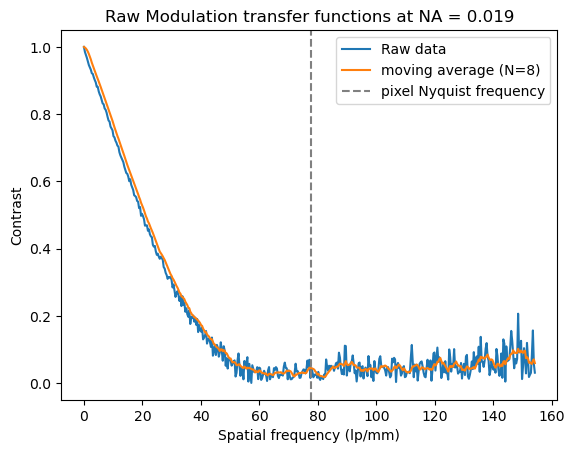

In [23]:
N = 8
array = f26[2][15]
new_array = np.concatenate([np.ones(N -1 ), array])
averaged = moving_average(new_array, N)
# plt.title('Moving averaged')

# plt.xlabel('Spatial frequency (lp/mm)')
# plt.ylabel('Contrast')

plt.plot(f26[0], f26[2][15], label='Raw data')

plt.plot(freqs, averaged, label='moving average (N=8)')
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Contrast')
plt.title('Raw Modulation transfer functions at NA = 0.019')

plt.axvline(x = nyquist_freq, color = 'gray', ls='--', label = 'pixel Nyquist frequency')
plt.legend()

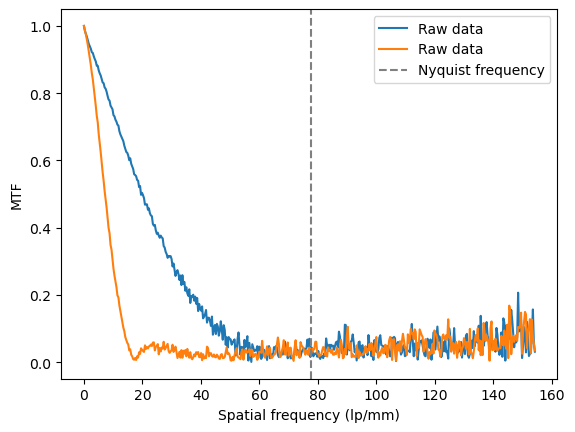

In [52]:
array = f26[2][15]
new_array = np.concatenate([np.ones(N -1 ), array])
averaged = moving_average(new_array, N)
# plt.title('Moving averaged')

# plt.xlabel('Spatial frequency (lp/mm)')
# plt.ylabel('Contrast')

plt.plot(f26[0], f26[2][15], label='Raw data')
plt.plot(f26[0], f26[2][0], label='Raw data')

# plt.plot(freqs, averaged, label='moving average (N=8)')
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('MTF')
# plt.title('Raw Modulation transfer functions at NA = 0.019')

plt.axvline(x = nyquist_freq, color = 'gray', ls='--', label = 'Nyquist frequency')
plt.legend()

### Interpolation in frequency direction

Now resample both the left and the right components.

Text(0, 0.5, 'Contrast')

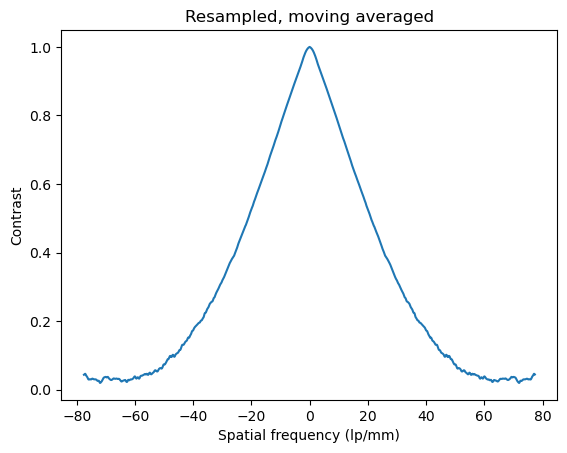

In [25]:
cs = CubicSpline(freqs, averaged)
N_pixels = 1040
frequencies = np.fft.fftfreq(1040, d=e)
right = cs(frequencies[0:N_pixels//2])
left = cs(-frequencies[N_pixels//2:])

plt.plot(fftshift(frequencies), np.concatenate([left, right]))
plt.title('Resampled, moving averaged')
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Contrast')

Now altogether

Text(0, 0.5, 'Contrast')

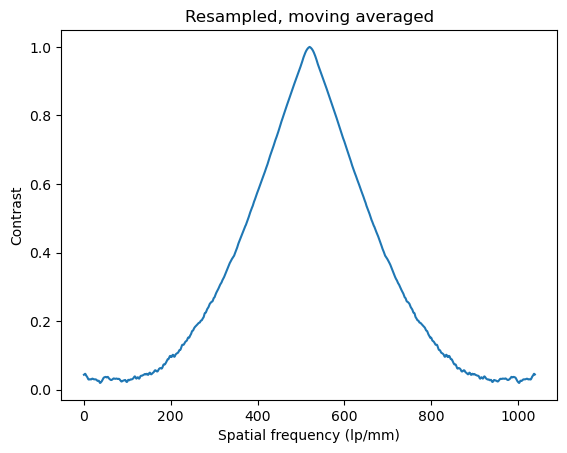

In [26]:
new_frequencies = np.fft.fftfreq(N_pixels, d=e)
plt.plot(get_resampled_mtf(f26[2][15], f26[0], new_frequencies))

plt.title('Resampled, moving averaged')
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Contrast')

### Now get the 2D filter
Need to resample and interpolate again

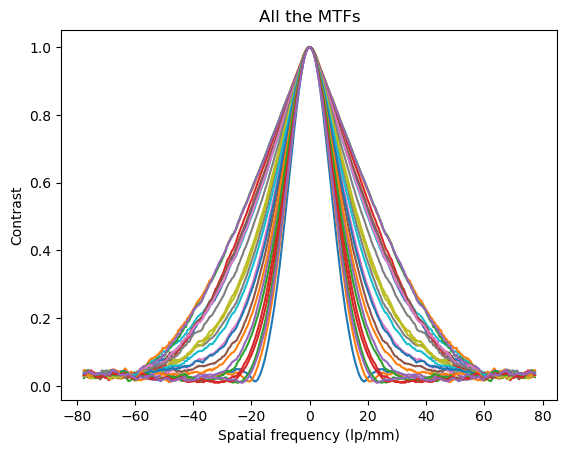

In [27]:
N_depths = len(depths)

measured_filter = np.zeros((N_depths, N_pixels))

for i in range(N_depths):
    plt.plot(fftshift(new_frequencies), get_resampled_mtf(f26[2][i], freqs, new_frequencies))
    plt.title('All the MTFs')
    plt.xlabel('Spatial frequency (lp/mm)')
    plt.ylabel('Contrast')

    measured_filter[i] = get_resampled_mtf(f26[2][i], freqs, new_frequencies)

Text(0.5, 1.0, 'MTF, defocus not interpolated yet')

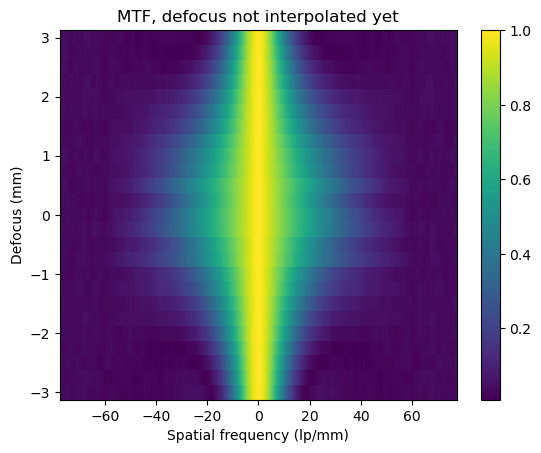

In [28]:
K, S = np.meshgrid(fftshift(new_frequencies), depths, )
plt.pcolormesh(K, S, measured_filter)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('MTF, defocus not interpolated yet')

### Now interpolate again

In [29]:
new_defocuses = np.linspace(-N_pixels * e /2, +N_pixels * e /2, N_pixels) # defocuses (mm)

Text(0.5, 1.0, '2D MTF, linear interpolation')

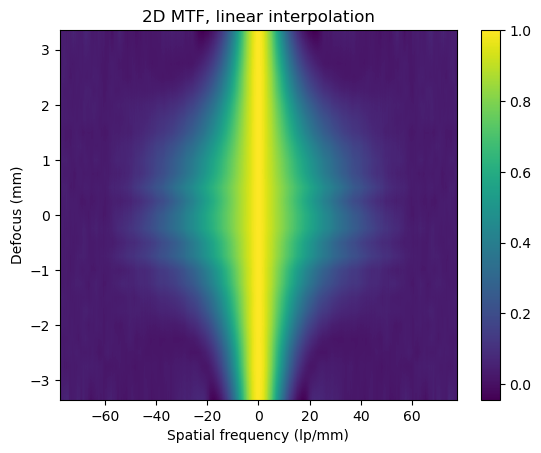

In [30]:
X, Y = np.meshgrid(fftshift(new_frequencies), new_defocuses, indexing='xy' )
interp = RegularGridInterpolator([fftshift(new_frequencies), depths], measured_filter.T, method='linear', bounds_error=False, fill_value= None)
result = interp((X,Y)).reshape(N_pixels, N_pixels)
plt.pcolormesh(X,Y, result)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('2D MTF, linear interpolation')

### Compare to what is measured

(0.0, 77.51937984496124)

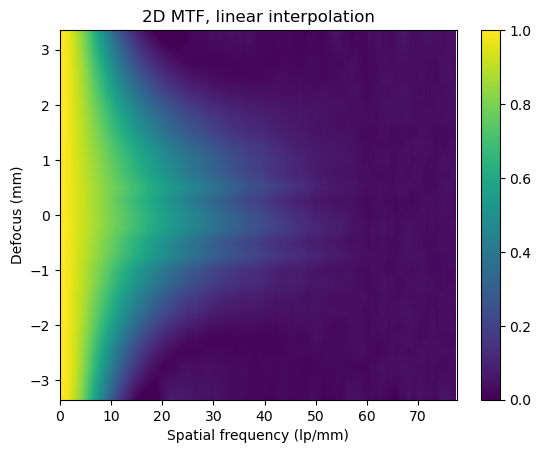

In [31]:
result[result<0] = 0
# plt.rcParams.update({'font.size': 15})
plt.pcolormesh(X,Y, result)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('2D MTF, linear interpolation')
plt.xlim(0, nyquist_freq)

Text(0.5, 1.0, 'MTF')

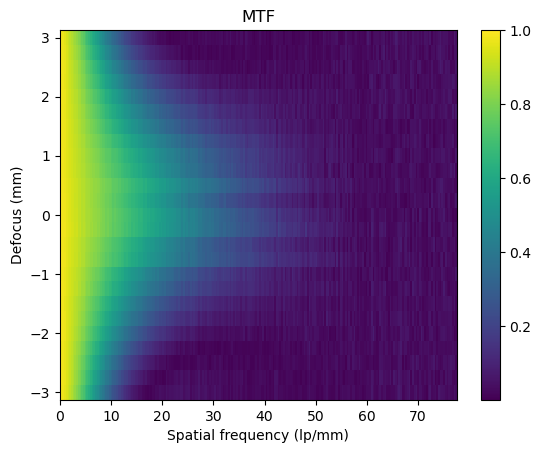

In [40]:
original_2d_mtf = np.zeros((len(freqs), len(depths)))
for i in range(len(depths)):
    original_2d_mtf[:,i] = f26[2][i]
plt.title('Original 2D MTF')
plt.pcolormesh(*np.meshgrid(freqs, depths), original_2d_mtf.T)
plt.xlim(0,nyquist_freq)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('MTF')

### Now altogether

In [33]:
new_frequencies = np.fft.fftfreq(N_pixels, d=e)
new_defocuses = np.linspace(-N_pixels * e /2, +N_pixels * e /2, N_pixels) # defocuses (mm)
X, Y = np.meshgrid(fftshift(new_frequencies), new_defocuses, indexing='xy' )

(0.0, 77.44484197972568)

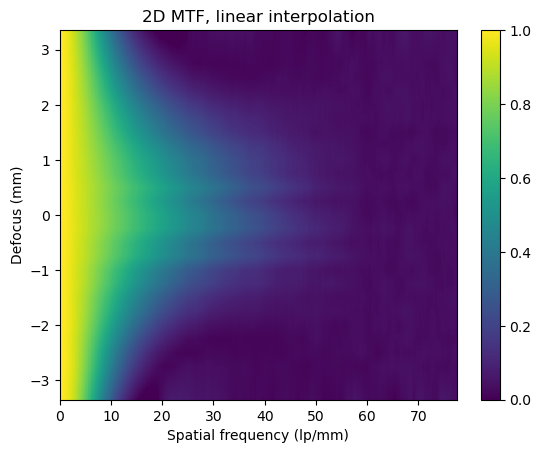

In [34]:
# plt.rcParams.update({'font.size': 10})
result = generate_interpolated_filter(f26, N_pixels, e)
plt.pcolormesh(X,Y, result)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('2D MTF, linear interpolation')
plt.xlim(0,)

---

## Proper analysis now

Here we do the same but for all the mtf_pickles. 

I just copy and pasted the code --> I should clean it up!

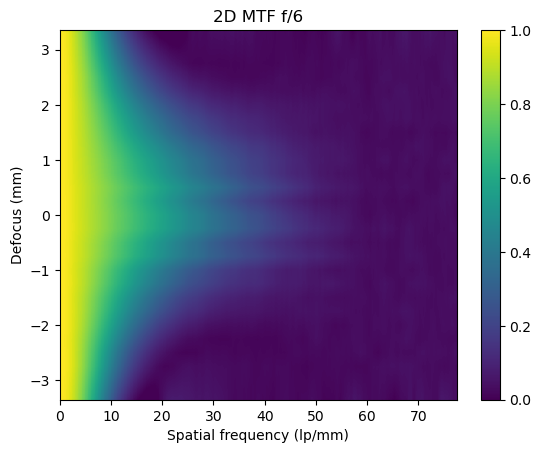

In [72]:
with open('../../OPT Shared files/3_Miscellaneous files/mtfs_no_subtract/f6_mtf.pickle', 'rb') as f:
    f6 = pickle.load(f)

result_f6 = generate_interpolated_filter(f6, N_pixels, e)
plt.pcolormesh(X,Y, result)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('2D MTF f/6')
plt.xlim(0,)
# with open('mtf_filters/f6_filter.pkl', 'wb') as f:
#     pickle.dump(result_f6, f)
# plt.savefig('f6.png', dpi=300)

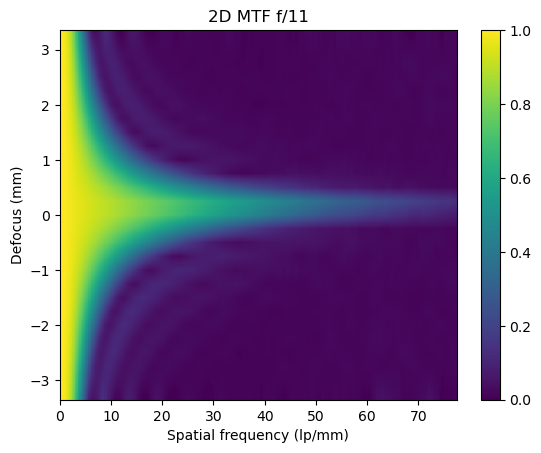

In [71]:
with open('../../OPT Shared files/3_Miscellaneous files/mtfs_no_subtract/f11_mtf.pickle', 'rb') as f:
    f11 = pickle.load(f)

result_f11 = generate_interpolated_filter(f11, N_pixels, e)
plt.pcolormesh(X,Y, result_f11)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.xlim(0,)
plt.title('2D MTF f/11')

# with open('mtf_filters/f11_filter.pkl', 'wb') as f:
#     pickle.dump(result_f11, f)
# plt.savefig('f11.png', dpi=300)

(0.0, 77.44484197972568)

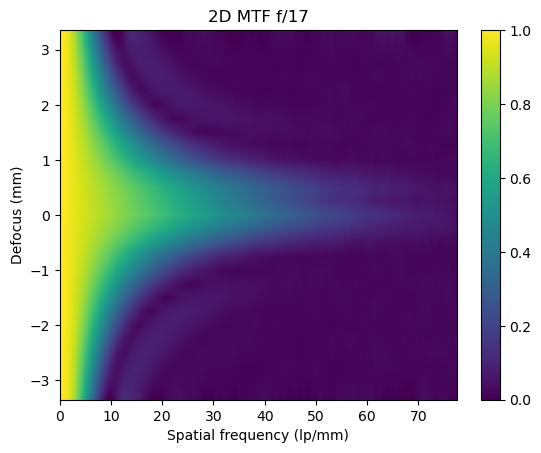

In [70]:
with open('../../OPT Shared files/3_Miscellaneous files/mtfs_no_subtract/f17_mtf.pickle', 'rb') as f:
    f17 = pickle.load(f)

result_f17 = generate_interpolated_filter(f17, N_pixels, e)
plt.pcolormesh(X,Y, result_f17)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('2D MTF f/17')

# with open('mtf_filters/f17_filter.pkl', 'wb') as f:
#     pickle.dump(result_f17, f)
plt.xlim(0,)
# plt.savefig('f17.png', dpi=300)

f26

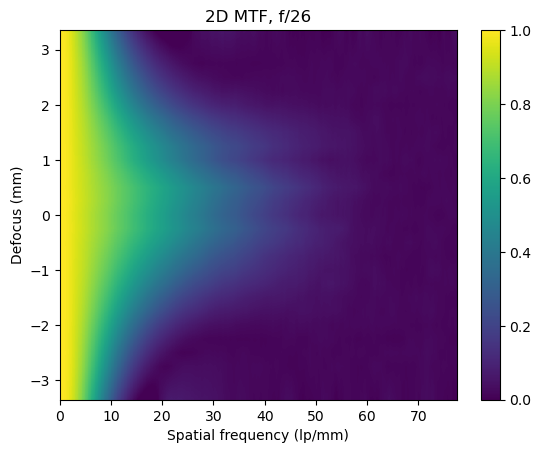

In [73]:
with open('../../OPT Shared files/3_Miscellaneous files/mtfs_no_subtract/f26_mtf.pickle', 'rb') as f:
    f26 = pickle.load(f)

result_f26 = generate_interpolated_filter(f26, N_pixels, e)
plt.pcolormesh(X,Y, result_f26)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('2D MTF, f/26')
plt.xlim(0,)
# with open('mtf_filters/f26_filter.pkl', 'wb') as f:
#     pickle.dump(result_f26, f)
# plt.savefig('f26.png', dpi=300)

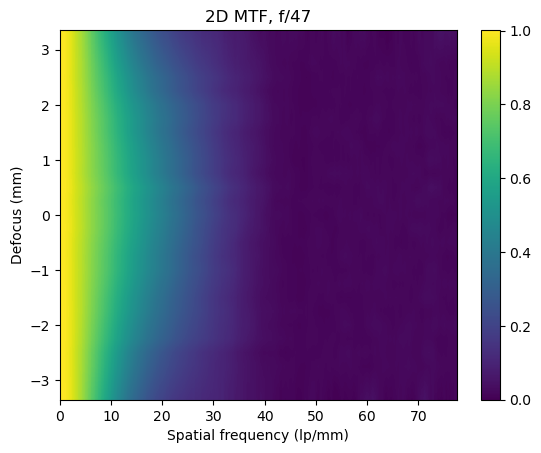

In [74]:
with open('../../OPT Shared files/3_Miscellaneous files/mtfs_no_subtract/f47_mtf.pickle', 'rb') as f:
    f47 = pickle.load(f)

result_f47 = generate_interpolated_filter(f47, N_pixels, e)
plt.pcolormesh(X,Y, result_f47)
plt.xlabel('Spatial frequency (lp/mm)')
plt.ylabel('Defocus (mm)')
plt.colorbar()
plt.title('2D MTF, f/47')
plt.xlim(0,)
# with open('mtf_filters/f47_filter.pkl', 'wb') as f:
#     pickle.dump(result_f47, f)
# plt.savefig('f26.png', dpi=300)

## Now export to MATLAB


In [39]:
mdict = {'f6':result_f6,
         'f11': result_f11,
         'f17': result_f17,
         'f26': result_f26}

# savemat('mtf_filters.mat', mdict)

---